In [1]:
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/dari-pasentran-ke-istana.gz
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/dari-pasentran-ke-istana-short.gz
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/turki-short.gz
# !wget https://raw.githubusercontent.com/huseinzol05/malaya-speech/master/data/semisupervised-audiobook/comma-dari-pasentran-ke-istana-sani.json
# !tar -xf turki-short.gz
# !tar -xf dari-pasentran-ke-istana-short.gz
# !tar -xf dari-pasentran-ke-istana.gz

In [2]:
import parselmouth
import librosa
import pyworld as pw
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

In [3]:
# !pip3 install malaya-gpu -U --no-deps

In [4]:
import yaml

with open('config.yaml') as fopen:
    config = yaml.load(fopen)
    
config

/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 20,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [5]:
import numpy as np

# https://github.com/TensorSpeech/TensorFlowTTS/blob/master/tensorflow_tts/utils/outliers.py
def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

In [6]:
import re

_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [7]:
import json

with open('comma-fullstop-pasentran-ke-istana.json') as fopen:
    pasentran = json.load(fopen)
    
with open('comma-fullstop-turki.json') as fopen:
    turki = json.load(fopen)
    
with open('comma-fullstop-pasentran-ke-istana-short.json') as fopen:
    pasentran_short = json.load(fopen)
    
with open('comma-fullstop-turki-short.json') as fopen:
    turki_short = json.load(fopen)
    
len(pasentran), len(turki), len(pasentran_short), len(turki_short)

(8746, 2166, 19529, 5485)

In [8]:
combined = {**turki, **pasentran, **pasentran_short, **turki_short}
len(combined)

35926

In [9]:
from glob import glob
from tqdm import tqdm

wavs = glob('*istana*/*istana*/*.wav')
wavs.extend(glob('*turki*/*turki*/*.wav'))
len(wavs)

38267

In [10]:
def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

In [86]:
from unidecode import unidecode
import malaya

normalizer = malaya.normalize.normalizer(date = False, time = False)

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, filename, normalize = True, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    string = re.sub(r'[ ]+', ' ', string).strip()
#     if string[-1] in '-,':
#         string = string[:-1]
#     if string[-1] not in '.,?!':
#         string = string + '.'
    
    if 'output-wav-dari-pasentran-ke-istana/' in filename:
        normalize_year = True
    elif 'output-wav-turki/' in filename:
        normalize_year = False
    
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True,
                                      normalize_year = normalize_year)
        string = string['normalize']
    else:
        string = string
    string = put_spacing_num(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string.lower()
    return string, tts_encode(string, add_eos = add_eos)

In [87]:
# [(no, i) for no, i in enumerate(txts)]

In [88]:
silent = np.load('silent-female.npy')

In [89]:
txts = [(k, v) for k, v in combined.items()]

In [90]:
import malaya_speech
from malaya_speech import Pipeline
vad = malaya_speech.vad.webrtc()

def process(txts, 
            start_silent_trail = int(0.01 * config['sampling_rate']),
            end_silent_trail = int(0.25 * config['sampling_rate']),
            process_middle_silent = True,
            maxlen = 25):
    txts = txts[0]
    audios, mels, text_ids, f0s, energies, pitches = [], [], [], [], [], []

    for f in tqdm(txts):
        text = f[1]
        f = f[0]
        f = f.replace('../youtube/malay/', '').replace('../youtube/malay2/', '')
        if re.match('^.*(RM|rm)[0-9]+.*$', text):
            continue
        text = cleaning(text, f)

        audio, _ = malaya_speech.load(f, sr = config['sampling_rate'])

        if (len(audio) / config['sampling_rate']) > maxlen:
            print('skipped, audio too long')
            continue

        if config['trim_silence']:
            y_= malaya_speech.resample(audio, config['sampling_rate'], 16000)
            y_ = malaya_speech.astype.float_to_int(y_)
            frames = list(malaya_speech.generator.frames(audio, 30, config['sampling_rate']))
            frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
            frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
            grouped_deep = malaya_speech.group.group_frames(frames_webrtc)
            grouped_deep = malaya_speech.group.group_frames_threshold(grouped_deep, 0.1)
            r = []
            for no, g in enumerate(grouped_deep):
                if g[1]:
                    g = g[0].array
                else:
                    if no == 0:
                        g = g[0].array[-start_silent_trail:]
                    elif no == (len(grouped_deep) - 1):
                        g = g[0].array[:end_silent_trail]
                    else:
                        if process_middle_silent:
                            g = np.concatenate([g[0].array[:end_silent_trail], g[0].array[-end_silent_trail:]])
                        else:
                            g = g[0].array
                        
                r.append(g)
            audio = np.concatenate(r)

        D = librosa.stft(
            audio,
            n_fft=config['fft_size'],
            hop_length=config['hop_size'],
            win_length=config['win_length'],
            window=config['window'],
            pad_mode='reflect',
        )
        S, _ = librosa.magphase(D) 
        fmin = 0 if config["fmin"] is None else config["fmin"]
        fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
        mel_basis = librosa.filters.mel(
            sr=config['sampling_rate'],
            n_fft=config["fft_size"],
            n_mels=config["num_mels"],
            fmin=fmin,
            fmax=fmax,
        )
        mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        audio = audio[: len(mel) * config['hop_size']]

        _f0, t = pw.dio(
            audio.astype(np.double),
            fs=config['sampling_rate'],
            f0_ceil=fmax,
            frame_period=1000 * config['hop_size'] / config['sampling_rate'],
        )
        f0 = pw.stonemask(audio.astype(np.double), _f0, t, config['sampling_rate'])
        if len(f0) >= len(mel):
            f0 = f0[: len(mel)]
        else:
            f0 = np.pad(f0, (0, len(mel) - len(f0)))

        # extract energy
        energy = np.sqrt(np.sum(S ** 2, axis=0))
        f0 = remove_outlier(f0)
        energy = remove_outlier(energy)
        
        mel_len = len(mel)
        snd = parselmouth.Sound(audio,sampling_frequency=22050)
        pitch = snd.to_pitch(time_step=snd.duration / (mel_len + 3)
                         ).selected_array['frequency']

        if config["global_gain_scale"] > 0.0:
            audio *= config["global_gain_scale"]

        if len(energy[energy != 0]) == 0 or len(f0[f0 != 0]) == 0:
            print('skipped')
            continue

        audios.append(audio)
        mels.append(mel)
        text_ids.append(text)
        f0s.append(f0)
        energies.append(energy)
        pitches.append(pitch)
    
    return [[audios, mels, text_ids, f0s, energies, pitches]]

In [91]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [92]:
i = 0
r = process((txts[i: i + 10],))[0]

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


In [97]:
k = 9

In [98]:
ipd.Audio(r[0][k], rate = 22050)

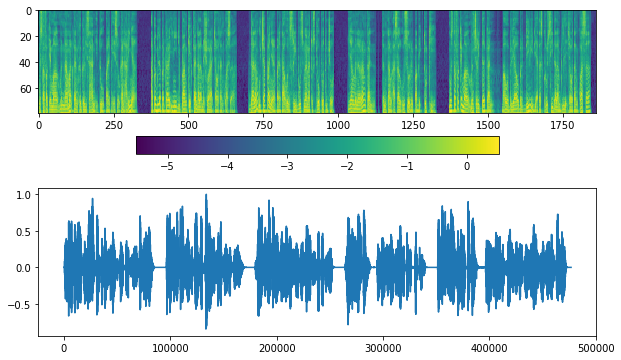

In [99]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(10)
fig.set_figheight(nrows * 3)
mel_outputs_ = np.reshape(r[1][k], [-1, 80])
im = ax[0].imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax[0])
ax[1].plot(r[0][k])
plt.show()

In [100]:
[i[0] for i in r[2]]

['muhyiddin berpikir , baru dia boleh mempergunakan cuma , sementara kamu pula mengharapkan perkenan raja baharunya , untuk mencapai cita - citanya ,',
 'harta kekalahan barisan pertahanan jerman yang terakhir di perbatasan barat pada julai seribu sembilan ratus lapan belas , sekalipun , tidak berupaya menyedarkan kerajaan itu , daripada sikap was - was nya ,',
 'terhadap empayar mereka , perbezaan tanggapan antara pemimpin tentera dan pemimpin awam ini ,',
 'slogan hari kebangsaan ini , menunjukkan , peranan utama pak turki muda dalam semua pertubuhan pertahanan diri awam tadi ,',
 'poskan dari dunia ini , sekali pula telah mendarat di antalya ,',
 'menghormati islam , tapi orang , tua akan melakukannya lebih baik jika kena dengan keadaannya dengan kata lain ,',
 'pada lapan februari , dengan menunggang seekor kuda perang berwarna putih , penduduk kristian tempatan bersorak gembira tidak terkata .',
 'dan memohon sokongan bolshevik kepada rancangan menggerakkan kaum muslim seluruh dun

In [101]:
import mp

audios, mels, text_ids, f0s, energies, pitches = [], [], [], [], [], []

In [102]:
for i in range(0, len(txts), 1000):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    results = mp.multiprocessing(b, process, cores = 10, returned = True)
    for result in results:
        audios.extend(result[0])
        mels.extend(result[1])
        text_ids.extend(result[2])
        f0s.extend(result[3])
        energies.extend(result[4])
        pitches.extend(result[5])

  5%|▌         | 5/100 [00:04<01:07,  1.40it/s]

skipped, audio too long


 23%|██▎       | 23/100 [00:20<01:18,  1.01s/it]

skipped, audio too long


 82%|████████▏ | 82/100 [01:06<00:11,  1.57it/s]

skipped, audio too long


 36%|███▌      | 36/100 [00:29<00:47,  1.35it/s]

skipped, audio too long


 41%|████      | 41/100 [00:35<00:48,  1.21it/s]

skipped, audio too long


 68%|██████▊   | 68/100 [00:58<00:23,  1.34it/s]

skipped, audio too long


 85%|████████▌ | 85/100 [01:07<00:11,  1.35it/s]

skipped, audio too long


 93%|█████████▎| 93/100 [01:20<00:04,  1.63it/s]

skipped, audio too long


 92%|█████████▏| 92/100 [00:55<00:03,  2.15it/s]

skipped


 23%|██▎       | 23/100 [00:13<00:41,  1.85it/s]

skipped


 23%|██▎       | 23/100 [00:14<00:53,  1.44it/s]

skipped


 41%|████      | 41/100 [00:25<00:32,  1.81it/s]

skipped


 43%|████▎     | 43/100 [00:25<00:22,  2.48it/s]

skipped


  1%|          | 1/100 [00:00<01:05,  1.50it/s]

skipped


 24%|██▍       | 24/100 [00:07<00:19,  3.96it/s]

skipped


 95%|█████████▌| 95/100 [00:25<00:01,  3.53it/s]

skipped


 36%|███▌      | 36/100 [00:09<00:12,  5.05it/s]

skipped


 64%|██████▍   | 64/100 [00:16<00:10,  3.29it/s]

skipped


  1%|          | 1/100 [00:00<00:21,  4.67it/s]

skipped


 20%|██        | 20/100 [00:05<00:18,  4.30it/s]

skipped


 43%|████▎     | 43/100 [00:11<00:11,  4.85it/s]

skipped


 51%|█████     | 51/100 [00:12<00:15,  3.24it/s]

skipped


  7%|▋         | 7/100 [00:02<00:28,  3.31it/s]

skipped


 27%|██▋       | 27/100 [00:07<00:21,  3.33it/s]

skipped


 50%|█████     | 50/100 [00:13<00:12,  4.05it/s]

skipped


 65%|██████▌   | 65/100 [00:17<00:08,  3.99it/s]

skipped


 13%|█▎        | 13/100 [00:04<00:30,  2.82it/s]

skipped


 85%|████████▌ | 85/100 [00:22<00:03,  4.08it/s]

skipped


 21%|██        | 21/100 [00:05<00:20,  3.88it/s]

skipped


 56%|█████▌    | 56/100 [00:16<00:12,  3.54it/s]

skipped


  5%|▌         | 5/100 [00:01<00:38,  2.48it/s]

skipped


 42%|████▏     | 42/100 [00:12<00:15,  3.73it/s]

skipped


 97%|█████████▋| 97/100 [00:24<00:00,  4.05it/s]

skipped


 96%|█████████▌| 96/100 [00:26<00:01,  3.71it/s]

skipped


 52%|█████▏    | 52/100 [00:13<00:11,  4.27it/s]

skipped


 25%|██▌       | 25/100 [00:08<00:20,  3.60it/s]

skipped


 39%|███▉      | 39/100 [00:12<00:14,  4.07it/s]

skipped


 82%|████████▏ | 82/100 [00:20<00:03,  4.75it/s]

skipped


 22%|██▏       | 22/100 [00:07<00:29,  2.65it/s]

skipped


 44%|████▍     | 44/100 [00:11<00:11,  4.73it/s]

skipped


 42%|████▏     | 42/100 [00:11<00:14,  3.99it/s]

skipped


 54%|█████▍    | 54/100 [00:14<00:10,  4.19it/s]

skipped


 63%|██████▎   | 63/100 [00:16<00:11,  3.31it/s]

skipped


  3%|▎         | 3/100 [00:01<00:54,  1.79it/s]

skipped


 22%|██▏       | 22/100 [00:06<00:19,  3.94it/s]

skipped


 28%|██▊       | 28/100 [00:07<00:15,  4.79it/s]

skipped


 38%|███▊      | 38/100 [00:10<00:17,  3.48it/s]

skipped


  3%|▎         | 3/100 [00:01<00:58,  1.67it/s]

skipped


 92%|█████████▏| 92/100 [00:23<00:02,  3.87it/s]

skipped


 97%|█████████▋| 97/100 [00:24<00:00,  4.37it/s]

skipped


 38%|███▊      | 38/100 [00:09<00:15,  3.89it/s]

skipped


 37%|███▋      | 37/100 [00:10<00:18,  3.47it/s]

skipped


 53%|█████▎    | 53/100 [00:12<00:10,  4.45it/s]

skipped


 55%|█████▌    | 55/100 [00:15<00:10,  4.37it/s]

skipped


 69%|██████▉   | 69/100 [00:18<00:07,  4.24it/s]

skipped


 66%|██████▌   | 66/100 [00:16<00:07,  4.59it/s]

skipped


 75%|███████▌  | 75/100 [00:19<00:06,  3.97it/s]

skipped


 91%|█████████ | 91/100 [00:22<00:01,  5.04it/s]

skipped


 38%|███▊      | 38/100 [00:09<00:14,  4.20it/s]

skipped


 56%|█████▌    | 56/100 [00:14<00:10,  4.20it/s]

skipped


 22%|██▏       | 22/100 [00:05<00:23,  3.38it/s]

skipped


 26%|██▌       | 26/100 [00:06<00:16,  4.47it/s]

skipped


 30%|███       | 30/100 [00:07<00:24,  2.89it/s]

skipped


 59%|█████▉    | 59/100 [00:14<00:13,  3.00it/s]

skipped


 98%|█████████▊| 98/100 [00:25<00:00,  4.16it/s]

skipped


 39%|███▉      | 39/100 [00:09<00:15,  3.89it/s]

skipped


  4%|▍         | 4/100 [00:01<00:38,  2.52it/s]

skipped


 24%|██▍       | 24/100 [00:05<00:19,  3.84it/s]

skipped


 49%|████▉     | 49/100 [00:15<00:12,  3.96it/s]

skipped


 61%|██████    | 61/100 [00:15<00:09,  3.94it/s]

skipped


 46%|████▌     | 46/100 [00:16<00:20,  2.63it/s]

skipped


 57%|█████▋    | 57/100 [00:21<00:19,  2.15it/s]

skipped


 11%|█         | 11/100 [00:03<00:24,  3.58it/s]

skipped


 80%|████████  | 80/100 [00:26<00:05,  3.92it/s]

skipped


 79%|███████▉  | 79/100 [00:28<00:08,  2.61it/s]

skipped


 82%|████████▏ | 82/100 [00:30<00:08,  2.24it/s]

skipped


 63%|██████▎   | 63/100 [00:22<00:11,  3.24it/s]

skipped


 28%|██▊       | 28/100 [00:09<00:23,  3.08it/s]

skipped


  4%|▍         | 4/92 [00:01<00:23,  3.72it/s]

skipped


 16%|█▋        | 15/92 [00:05<00:23,  3.34it/s]

skipped


 92%|█████████▏| 85/92 [00:29<00:02,  2.53it/s]

skipped


100%|██████████| 92/92 [00:32<00:00,  2.79it/s]


In [103]:
len(mels)

35842

In [104]:
stats = np.load('/home/husein/speech-bahasa/male-stats-v3/stats.npy')
stats.shape

(2, 80)

In [105]:
scaler_mel = StandardScaler()
scaler_mel.mean_ = stats[0]
scaler_mel.scale_ = stats[1]

In [106]:
# scaler_mel = StandardScaler(copy=False)
# scaler_energy = StandardScaler(copy=False)
# scaler_f0 = StandardScaler(copy=False)
# scaler_pitch = StandardScaler(copy=False)

# for mel, f0, energy, pitch in zip(mels, f0s, energies, pitches):

#     scaler_mel.partial_fit(mel)
#     scaler_energy.partial_fit(energy[energy != 0].reshape(-1, 1))
#     scaler_f0.partial_fit(f0[f0 != 0].reshape(-1, 1))
#     scaler_pitch.partial_fit(pitch[pitch != 0].reshape(-1, 1))

In [107]:
for i in tqdm(range(len(mels))):
    mels[i] = scaler_mel.transform(mels[i])

100%|██████████| 35842/35842 [00:08<00:00, 4226.23it/s]


In [108]:
# directory_stats = 'male-stats-v3'

In [109]:
# def save_statistics_to_file(scaler_list, config):
#     os.system(f'mkdir {directory_stats}')
#     for scaler, name in scaler_list:
#         stats = np.stack((scaler.mean_, scaler.scale_))
#         np.save(
#             os.path.join(f"{directory_stats}/stats{name}.npy"),
#             stats.astype(np.float32),
#             allow_pickle=False,
#         )

In [110]:
# scaler_list = [(scaler_mel, ""), (scaler_energy, "_energy"), (scaler_f0, "_f0"),
#               (scaler_pitch, "_pitch")]
# save_statistics_to_file(scaler_list, config)

In [111]:
directory = 'output-male-v4'

In [112]:
!rm -rf {directory}

In [113]:
os.system(f'mkdir {directory}')
directories = ['audios', 'mels', 'text_ids', 'f0s', 'energies', 'pitches']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [114]:
for i in tqdm(range(len(mels))):
    np.save(f'{directory}/audios/{i}.npy', audios[i])
    np.save(f'{directory}/mels/{i}.npy', mels[i])
    np.save(f'{directory}/text_ids/{i}.npy', text_ids[i])
    np.save(f'{directory}/f0s/{i}.npy', f0s[i])
    np.save(f'{directory}/energies/{i}.npy', energies[i])
    np.save(f'{directory}/pitches/{i}.npy', pitches[i])

100%|██████████| 35842/35842 [05:18<00:00, 112.56it/s]
